In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from tqdm import tqdm
from quetzal.model import stepmodel
from syspy.skims import skims
from quetzal.io import excel

# Emissions modelling
## Saves emissions from passenger transport
## Needs inner- and intra-zonal passenger kilometer by mode

In [3]:
input_path = '../input_static/'
output_path = '../output/' + scenario + '/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]

### Load results

In [5]:
sm = stepmodel.read_zippedpickles(model_path + scenario + '/' + 'de_assignment')
try:
    z = stepmodel.read_json(model_path + scenario + '/' + 'de_zones')
except FileNotFoundError:
    z = stepmodel.read_json(model_path + 'base/' + 'de_zones')
sm.zones = z.zones

nodes: 100%|██████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


### Road link vkm

In [6]:
# Filter unused road links
sm.road_links = sm.road_links.loc[(sm.road_links["volume"].notna())
                                  & (sm.road_links["volume"]>0)]
len(sm.road_links)

148076

In [7]:
# Calculate vehicle kilometers by demand segment
# As done in model_assignment_inner-zone
occ_dict = params['car_occ'] # MiD2017 data, see cal10
sm.road_links['vkm'] = sm.road_links["volume"] \
    * sm.road_links['length']/1000 / occ_dict['all']
#for seg in segments:
#    sm.road_links['vkm'] += sm.road_links[(seg, 'car')] \
#        * sm.road_links['length']/1000 / occ_dict[seg]#[0]]
sm.road_links['vkm'] = sm.road_links['vkm'].astype(int)

In [8]:
# Sum up vkm by region and speed limit
sm.road_links['NUTS1'] = sm.road_links['NUTS3'].str[:3]
inter_car = sm.road_links.groupby(['NUTS1', 'maxspeed']).agg({'vkm': 'sum'})

### PT link mapping and pkm

In [9]:
# Drop unused PT links
sm.links = sm.links.loc[(sm.links['volume'].notna()) & (sm.links['volume']>0)]

In [10]:
# Generate length for PT links if not done yet
if 'length' not in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(
        sm.links['geometry']).astype(int)

In [11]:
# Emissions from PT are considered in the service's origin
sm.links['NUTS1'] = sm.links['a'].map(sm.nodes['FID'].str[:3])
sm.links['pkm'] = sm.links['length']/1000 * sm.links['volume']
inter_pt = sm.links.groupby(['NUTS1', 'route_type']).agg({'pkm': 'sum'})

### Merge with inner-zonal traffic

In [12]:
# Load results of inner-zonal traffic
inner = pd.read_excel(output_path + 'inner_zone.xlsx', sheet_name='agg', index_col=[0,1])
inner = inner.rename(index={'rail': 'rail_short'})

In [13]:
# Combine results
sm.road_links['pkm'] = sm.road_links["volume"] * sm.road_links['length']/1000
sm.road_links['route_type'] = 'car'
all_pkm = sm.road_links.groupby(['NUTS1', 'route_type']).agg({'pkm': 'sum'}).append(inter_pt)
inner.index.rename(['NUTS1', 'route_type'], inplace=True)
all_pkm = all_pkm.merge(inner['pkm'], how='outer', left_index=True,
                        right_index=True, suffixes=['_inter', '_inner']).fillna(0)
all_pkm['pkm'] = all_pkm['pkm_inter'] + all_pkm['pkm_inner']

array([<Axes: >], dtype=object)

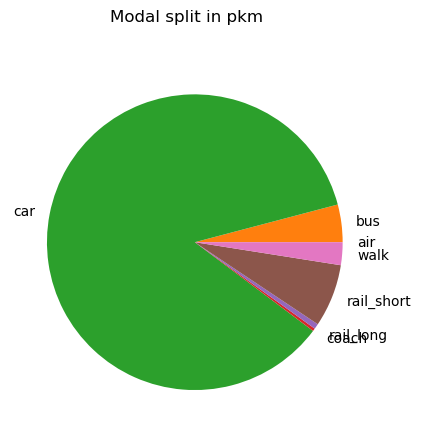

In [14]:
all_pkm['pkm'].unstack().sum(axis=0).plot.pie(subplots=True, title='Modal split in pkm')

In [15]:
print("Mode shares in percent")
mode_agg = {'tram': 'bus', 'subway': 'bus', 'ferry': 'bus', 'funicular': 'bus', 'coach': 'bus',
            'rail_long': 'rail', 'rail_short': 'rail'}
total = all_pkm['pkm'].sum()
pkm_shares_percent = all_pkm.rename(index=mode_agg).groupby(level=1).agg({'pkm': 'sum'})/total*100 
print(pkm_shares_percent)

Mode shares in percent
                  pkm
route_type           
air          0.000074
bus          4.408132
car         85.650906
rail         7.449306
walk         2.491582


In [16]:
pkm_total = pd.DataFrame(data = {"bn. pkm" : [round(total/1e9,5)]}, index=['total'])
print('Total traffic (billion pkm):')
print(pkm_total)

Total traffic (billion pkm):
          bn. pkm
total  1183.86803


In [17]:
print("Mode shares in total (billion pkm)")
pkm_shares_total = all_pkm.rename(index=mode_agg).groupby(level=1).agg({'pkm': 'sum'})/1e9
pkm_shares_total.columns = ['bn. pkm']
pkm_shares_total = pd.concat([pkm_shares_total, pkm_total])
print(pkm_shares_total)

Mode shares in total (billion pkm)
           bn. pkm
air       0.000873
bus      52.186467
car    1013.993693
rail     88.189956
walk     29.497038
total  1183.868030


In [18]:
# Merge car vkm
car_vkm = inner.xs('car', level=1)[['vkm']].merge(
    inter_car.groupby(level=0).sum()['vkm'], how='outer', left_index=True,
    right_index=True, suffixes=['_inner', '_inter']).fillna(0)
car_vkm['vkm'] = car_vkm['vkm_inter'] + car_vkm['vkm_inner']

In [19]:
print('Average vkm per year by roughly 46 Mio. cars in Germany 2017 (GENESIS database)')
car_vkm_total = pd.DataFrame(data = {"vkm" : [car_vkm['vkm'].sum() / params['vehicles']['car']]}, index=['total'])
print(car_vkm_total)

Average vkm per year by roughly 46 Mio. cars in Germany 2017 (GENESIS database)
                vkm
total  16882.436289


In [20]:
print('thereof inner model zones')
car_vkm_inner = pd.DataFrame(data = {"vkm" : [car_vkm['vkm_inner'].sum() / params['vehicles']['car']]}, index=['inner'])
print(car_vkm_inner)

thereof inner model zones
              vkm
inner  3913.40371


In [21]:
print('thereof inter model zones')
car_vkm_inter = pd.DataFrame(data = {"vkm" : [car_vkm['vkm_inter'].sum() / params['vehicles']['car']]}, index=['inner'])
print(car_vkm_inter)

thereof inter model zones
                vkm
inner  12969.032578


In [22]:
print('Official values for 2017 from TREMOD')
car_vkm_off = pd.DataFrame(data = {"vkm" : [round(656800000000 / params['vehicles']['car'],6)]}, index=['official'])
print(car_vkm_off)

Official values for 2017 from TREMOD
                   vkm
official  14290.662369


In [23]:
print('Average car vkm per year')
vkm_car_all = pd.concat([car_vkm_total, car_vkm_inner, car_vkm_inter, car_vkm_off])
print(vkm_car_all)

Average car vkm per year
                   vkm
total     16882.436289
inner      3913.403710
inner     12969.032578
official  14290.662369


## Calculate PT vehicle loads

While vkm of car traffic are straight forward (using average occupancies and pkm), PT vkm strongly depend on the transport supply system. They can be modelled using average occupancy factors of PT/sharing vehicles (as for private cars), or depend on vehicle circulations that are statically defined in schedules.

Absolute road PT vkm values can be retrieved from BMVI 2018, "Verkehr in Zahlen 2018/19", p. 81. Rail vkm can be generated endogenously using GTFS feeds.

Scientific thoughts regarding a thorough and computational efficient method can be found here: https://doi.org/10.1016/j.procs.2021.03.022

In [24]:
# Use PT load factors calculated from 2018 values.
# They are already included into below emission factors per pkm.

## Calculate emissions from vkm

Reference emissions for 2019 (no change compared to 2017) from passenger traffic in Germany are 164 Mio. tCO2eq * (60.8(car)+1.4(air)+0.3(rail)+XXX(bus)=65)% = 107 Mio. tCO2eq

Source: Bundesministerium für Umwelt, Naturschutz und nukleare Sicherheit (2021): Klimaschutz in Zahlen - Fakten, Trends und Impulse deutscher Klimapolitik Ausgabe 2021, p. 36

Data sources for emission factors in this model are
* vkm car: TREMOD (Transport Emission Model; underlying values come from HBEFA (Handbuch Emissionsfaktoren)): "Aktualisierung der Modelle TREMOD/TREMOD-MM für die Emissionsberichterstattung 2020 (Berichtsperiode 1990-2018)", 2020
* pkm PT: UBA (Umweltbundesamt): "Vergleich der durchschnittlichen Emissionen einzelner Verkehrsmittel im Personenverkehr in Deutschland", 2020

In [25]:
em_dict = params['emissions']

In [26]:
# Cars
# In 2017, there were 66% petrol and 33% diesel cars, rest is mainly LPG (TREMOD, p. 43)
# Take REAL average emissions in gCO2eq/km (TREMOD, p. 54)
car_em = 0.66*173.6 + 0.33*187.6 + 0.01*104
inter_car['tCO2eq'] = inter_car['vkm'] * em_dict['car'] / 1e6

In [27]:
# PT (UBA)
inter_pt['tCO2eq'] = inter_pt['pkm'] * inter_pt.index.get_level_values(1).map(em_dict) / 1e6

In [28]:
# Inner-zonal
mask = (inner.index.get_level_values(1)=='car')
inner.loc[mask,'tCO2eq'] = inner.loc[mask,'vkm'] * \
    inner.loc[mask].index.get_level_values(1).map(em_dict) / 1e6
inner.loc[~mask,'tCO2eq'] = inner.loc[~mask,'pkm'] * \
    inner.loc[~mask].index.get_level_values(1).map(em_dict) / 1e6

In [29]:
print('Local transport emissions (mio. tonnes):')
emiss_short = inner.groupby('route_type').agg({'tCO2eq': 'sum'}) / 1e6
emiss_short.columns = ['mio tCO2eq']
print(emiss_short)

Local transport emissions (mio. tonnes):
            mio tCO2eq
route_type            
bus           2.065267
car          31.929529
rail_short    0.667715
walk          0.000000


In [30]:
print("CAR: Long-distance transport emissions (mio. tonnes): ")
emiss_car_long = pd.DataFrame(data = {"mio tCO2eq" : [inter_car['tCO2eq'].sum()/1e6]}, index = ['car_long'])
print(emiss_car_long)

CAR: Long-distance transport emissions (mio. tonnes): 
          mio tCO2eq
car_long  105.814563


In [31]:
print("PT: Long-distance transport emissions (mio. tonnes): ")
emiss_pt_long = inter_pt.groupby('route_type').agg({'tCO2eq': 'sum'}) / 1e6
emiss_pt_long.columns = ['mio tCO2eq']
print(emiss_pt_long)

PT: Long-distance transport emissions (mio. tonnes): 
            mio tCO2eq
route_type            
air           0.000187
bus           1.821723
coach         0.115171
rail_long     0.197918
rail_short    3.807370


In [32]:
print("Long-distance transport emissions (mio. tonnes): ")
emiss_long = pd.concat([emiss_pt_long, emiss_car_long])
print(emiss_long)

Long-distance transport emissions (mio. tonnes): 
            mio tCO2eq
air           0.000187
bus           1.821723
coach         0.115171
rail_long     0.197918
rail_short    3.807370
car_long    105.814563


In [33]:
# Drop speeds in car km
inter_car = inter_car.groupby(level=0).sum()
inter_car['route_type'] = 'car'
inter_car.set_index('route_type', append=True, inplace=True)

In [34]:
# Merge emissions together
all_em = inter_pt[['tCO2eq']].append(inter_car[['tCO2eq']]).append(inner[['tCO2eq']])
all_em = all_em.groupby(level=[0,1]).sum()

<Axes: xlabel='NUTS1'>

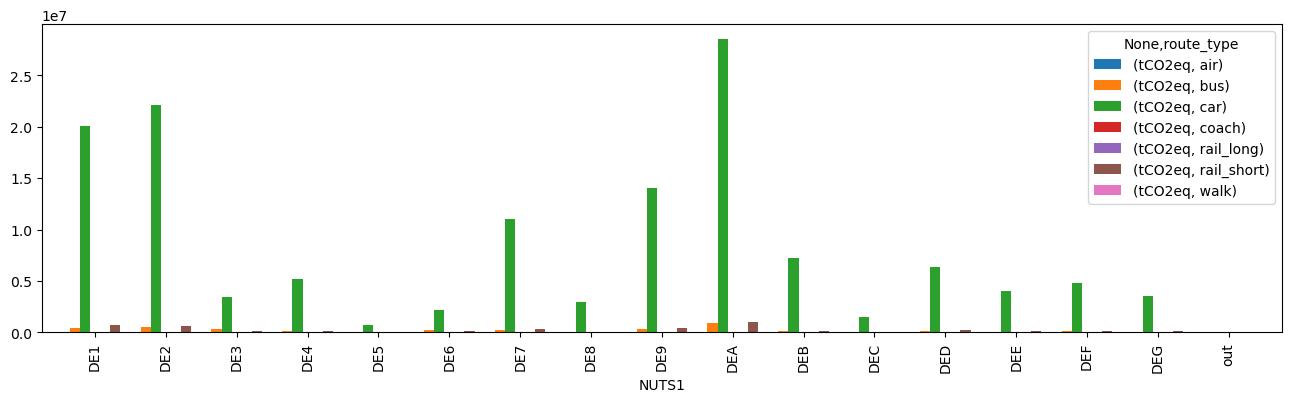

In [35]:
# Emissions by region and mode
all_em.unstack().plot.bar(subplots=False, figsize=(16,4), width=1)

## Save
Create one ecxel output with pkm, emissions, time and cost.

In [36]:
# Load inter-zonal aggregated results
inter = pd.read_excel(output_path + 'inter_zone.xlsx',
                      sheet_name='od', index_col=[0,1,2])
# Get time and price weighted averages by origin and mode
weighted_av = lambda x: np.average(x, weights=inter.loc[x.index, 'volume'])
inter = inter.groupby(level=[0,2]).agg(
    volume=('volume', 'sum'),
    time=('time', weighted_av),
    length=('length', weighted_av))
inter.index.rename(['NUTS1', 'route_type'], inplace=True)
# Sums
for col in ['time', 'length']:
    inter[col] = inter[col] * inter['volume']

In [37]:
# Merge times
time = inter[['time']].merge(
    (inner['time']*inner['volumes']).rename('time'), how='outer',
    left_index=True, right_index=True, suffixes=['_inter', '_inner']).fillna(0)
time['time'] = time['time_inter'] + time['time_inner']

In [38]:
# Average car operating hours per day per car
time.xs('car', level=1)['time'].sum() / params['vehicles']['car'] / 365

0.23825897779612412

In [39]:
# Merge prices
if 'price' in inter.columns:
    price = inter[['price']].merge(
        (inner['price']*inner['volumes']).rename('price'), how='outer',
        left_index=True, right_index=True, suffixes=['_inter', '_inner']).fillna(0)
    price['price'] = price['price_inter'] + price['price_inner']

In [40]:
# Save data disaggregated by regions to excel
with pd.ExcelWriter(output_path + 'results_agg.xlsx') as writer:  
    all_pkm.to_excel(writer, sheet_name='pkm')
    car_vkm.to_excel(writer, sheet_name='car_vkm')
    all_em.to_excel(writer, sheet_name='emissions')
    time.to_excel(writer, sheet_name='time')
    if 'price' in inter.columns: price.to_excel(writer, sheet_name='price')

In [41]:
# Save total values to excel
with pd.ExcelWriter(output_path + 'results_total.xlsx') as writer:  
    pkm_shares_percent.to_excel(writer, sheet_name='pkm_shares_percent')
    pkm_shares_total.to_excel(writer, sheet_name='pkm_shares_total')
    vkm_car_all.to_excel(writer, sheet_name='average_vkm_car_yr')
    emiss_short.to_excel(writer, sheet_name='emissions_local')
    emiss_long.to_excel(writer, sheet_name='emissions_long')

### Save disaggregated results

In [42]:
# inter-zonal pkm
inter_car = sm.road_links.groupby('NUTS3').agg({"pkm": 'sum'})
sm.links['NUTS3'] = sm.links['a'].map(sm.nodes['FID'].str[:5])
inter_pt = sm.links.groupby(['NUTS3', 'route_type']).agg({'pkm': 'sum'})
inter_car['route_type'] = 'car'
inter = inter_car.groupby(['NUTS3', 'route_type']).agg({'pkm': 'sum'}).append(inter_pt)

In [43]:
# Load inner-zonal disaggregated pkm
inner = pd.read_csv(output_path + 'inner_zone_pkm.csv', header=[0,1], index_col=0)
inner = inner.stack('mode').reset_index().replace({'rail': 'rail_short', 'non-motorised': 'walk'})
inner['origin'] = inner['origin'].str[:5] # NUTS3
inner = inner.groupby(['origin', 'mode']).sum().sum(axis=1)

In [44]:
# All together
inter.index.names = inner.index.names
all_pkm = pd.merge(inner.rename('pkm'), inter, how='outer',
                   left_index=True, right_index=True).fillna(0)
all_pkm['pkm'] = all_pkm['pkm_x'] + all_pkm['pkm_y']

In [45]:
# Save
all_pkm[['pkm']].to_csv(output_path + 'pkm.csv')